<a href="https://colab.research.google.com/github/kridtapon/Hull-Moving-Average-Crossover-Strategy-Heatmap/blob/main/Hull_Moving_Average_Crossover_Strategy_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

[*********************100%***********************]  1 of 1 completed


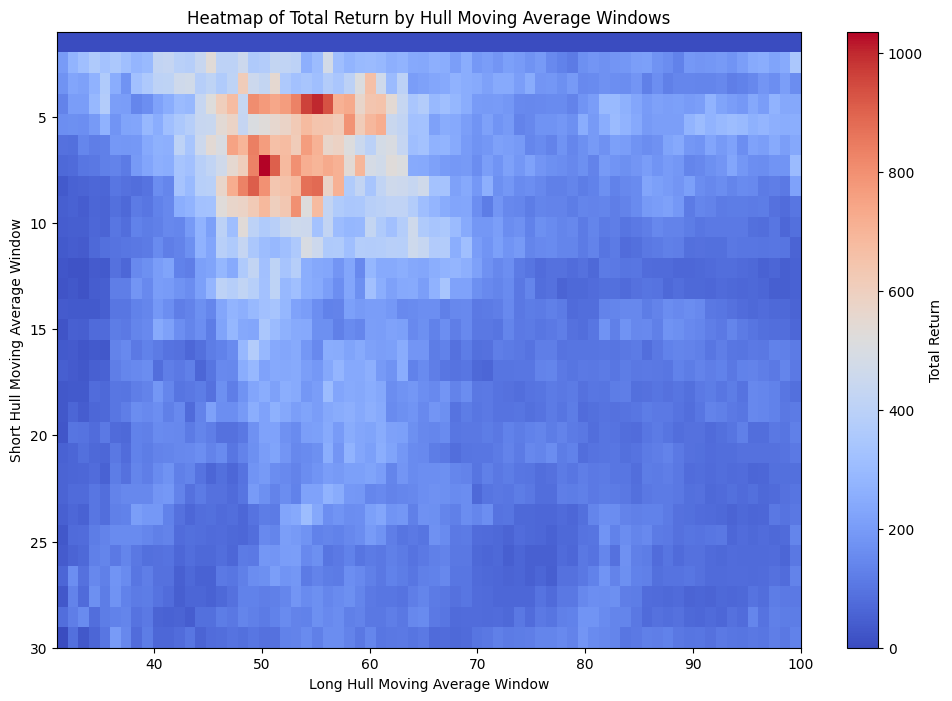

Best Short Window: 7
Best Long Window: 50
Best Performance: 103555.60%


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate Hull Moving Average (HMA)
def calculate_hma(series, window):
    """Calculate Hull Moving Average (HMA)."""
    half_window = int(window / 2)
    sqrt_window = int(np.sqrt(window))

    wma_half = series.rolling(window=half_window).mean()
    wma_full = series.rolling(window=window).mean()
    raw_hma = 2 * wma_half - wma_full

    return raw_hma.rolling(window=sqrt_window).mean()

# Calculate short long hull moving averages (HMA)
def calculate_hull_moving_averages(df, short_window, long_window):
    """Calculate short-term and long-term Hull Moving Averages."""
    df['Short_HMA'] = calculate_hma(df['Close'], short_window)
    df['Long_HMA'] = calculate_hma(df['Close'], long_window)
    return df

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2014-12-25'
end_date = '2024-12-25'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Optimization range for moving average windows
short_window_range = range(1, 31)  # Example: 5 to 30
long_window_range = range(31, 101)  # Example: 30 to 100

# Initialize heatmap results
heatmap_results = np.full((len(short_window_range), len(long_window_range)), np.nan)

# Perform grid search
for i, short_window in enumerate(short_window_range):
    for j, long_window in enumerate(long_window_range):
        if short_window >= long_window:
            continue  # Skip invalid combinations where short_window >= long_window

        # Calculate Hull Moving Averages
        temp_df = calculate_hull_moving_averages(df.copy(), short_window, long_window)

        # Define entry and exit signals
        temp_df['Entry'] = (
            (temp_df['Short_HMA'] > temp_df['Long_HMA']) &
            (temp_df['Short_HMA'].shift(1) <= temp_df['Long_HMA'].shift(1))
        )
        temp_df['Exit'] = (
            (temp_df['Short_HMA'] < temp_df['Long_HMA']) &
            (temp_df['Short_HMA'].shift(1) >= temp_df['Long_HMA'].shift(1))
        )

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=temp_df['Close'],
            entries=temp_df['Entry'].to_numpy(),
            exits=temp_df['Exit'].to_numpy(),
            init_cash=100_000,
            fees=0.001
        )

        # Store performance in heatmap
        performance = portfolio.total_return()
        heatmap_results[i, j] = performance

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_results,
    cmap='coolwarm',
    interpolation='nearest',
    extent=[
        long_window_range.start,
        long_window_range.stop - 1,
        short_window_range.stop - 1,
        short_window_range.start,
    ],
    aspect='auto',
)
plt.colorbar(label='Total Return')
plt.title('Heatmap of Total Return by Hull Moving Average Windows')
plt.xlabel('Long Hull Moving Average Window')
plt.ylabel('Short Hull Moving Average Window')
plt.show()

# Extract best combination for reference
max_return_idx = np.unravel_index(np.nanargmax(heatmap_results), heatmap_results.shape)
best_short_window = short_window_range.start + max_return_idx[0]
best_long_window = long_window_range.start + max_return_idx[1]

print(f"Best Short Window: {best_short_window}")
print(f"Best Long Window: {best_long_window}")
print(f"Best Performance: {heatmap_results[max_return_idx]:.2%}")


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate Hull Moving Average (HMA)
def calculate_hma(df, window):
    """Calculate the Hull Moving Average."""
    half_length = window // 2
    sqrt_length = int(np.sqrt(window))

    wma_half = df['Close'].rolling(window=half_length).mean()
    wma_full = df['Close'].rolling(window=window).mean()

    raw_hma = 2 * wma_half - wma_full
    hma = raw_hma.rolling(window=sqrt_length).mean()

    return hma

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2014-12-25'
end_date = '2024-12-25'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Hull Moving Averages
df['Short_HMA'] = calculate_hma(df, window=7)
df['Long_HMA'] = calculate_hma(df, window=50)

# Define entry and exit signals based on HMA crossover
df['Entry'] = (
    (df['Short_HMA'] > df['Long_HMA']) &  # Short-term HMA crosses above Long-term HMA
    (df['Short_HMA'].shift(1) <= df['Long_HMA'].shift(1))  # Previous Short-term HMA was below Long-term HMA
)

df['Exit'] = (
    (df['Short_HMA'] < df['Long_HMA']) &  # Short-term HMA crosses below Long-term HMA
    (df['Short_HMA'].shift(1) >= df['Long_HMA'].shift(1))  # Previous Short-term HMA was above Long-term HMA
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2014-12-25 00:00:00
End                                  2024-12-23 00:00:00
Period                                3652 days 00:00:00
Start Value                                     100000.0
End Value                               103655595.176957
Total Return [%]                           103555.595177
Benchmark Return [%]                        29581.463628
Max Gross Exposure [%]                             100.0
Total Fees Paid                           5992375.915669
Max Drawdown [%]                               61.800426
Max Drawdown Duration                 1106 days 00:00:00
Total Trades                                         113
Total Closed Trades                                  113
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   50.442478
Best Trade [%]                                100.455378
Worst Trade [%]                